In [475]:
import os
import pandas as pd
from tqdm import tqdm
import datetime
from random import randint
import numpy as np
from glob import glob
import json
import forecastio
from fuzzywuzzy import process
from bokeh.plotting import *
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
from scipy import stats
from geopy.geocoders import Nominatim as nm
from geopy.distance import vincenty
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

Loading BokehJS ...

In [196]:
os.chdir('/home/valesco/Datasets/PGA_Data/15th Club/')
horsey_df = pd.read_csv('hackathon-data-horsey.csv')
course_loc = pd.read_csv('euro_tour_courses.csv')
strokes_gained = pd.read_csv('/home/valesco/Datasets/PGA_Data/PGA_strokes_gained.csv', index_col = 0)

In [3]:
horsey_df.head()

,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction
0,2016-11-18,2,13,1,NaN,True,7560,360.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Tee,iron,center
1,2016-11-18,2,13,2,True,True,360,12.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Green,putter,short
2,2016-11-18,2,13,3,True,True,12,1.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Hole,Green,putter,center
3,2016-11-18,2,18,1,NaN,True,19440,9324.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Tee,driver,center
4,2016-11-18,2,18,2,NaN,True,9324,2520.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Fairway,iron,center


In [43]:
course_ls = horsey_df['name'].unique()
course_dict = {}
for course in course_ls:
    course_id_df = pd.DataFrame(horsey_df.loc[horsey_df['name'] == course, 'course_id'])
    
    course_ids = course_id_df['course_id'].unique()
    
    for ids in course_ids:
        if len(course_ids) > 1:
            course_dict[course] = course_ids
        else:
            course_dict[course] = course_ids[0]

In [479]:
def calc_miles(df):
    distance = vincenty(home_coords, (df['lat'], df['long'])).miles
    return distance


geolocator = nm()
home_coords = geolocator.geocode('Alderley Edge, England')
home_coords = home_coords[1]



course_loc = pd.read_csv('euro_tour_courses.csv')

course_loc['miles_dist'] = course_loc.apply(calc_miles, axis = 1)
course_loc

,course_id,num_courses,tournament_name,course_name,lat,long,miles_dist
0,26,1,100th Open de France,Le Golf National,48.752200,2.08510,366.711352
1,64,1,AAM Scottish Open,Castle Stuart,57.528000,-4.10600,301.161854
2,16,3,Alfred Dunhill Links Championship,St. Andrews,56.343000,-2.80300,211.292364
3,17,3,Alfred Dunhill Links Championship,Carnoustie,56.497000,-2.71700,221.563567
4,18,3,Alfred Dunhill Links Championship,Kingsbarn,56.300000,-2.65000,207.762704
5,63,1,BMW International,Golfclub München Eichenried,48.276000,11.77500,703.817826
6,95,1,British Masters,The Grove,51.677325,-0.43632,135.852918
7,5,1,Real Czech Masters,The Albatross,49.995000,14.20100,741.125162
8,48,1,"Dp World Tour Championship, Dubai","The Earth Course, Jumeirah Golf Estates",25.022000,55.19900,3521.517025
9,12,1,Italian Open,Golf Club Milano,45.616000,9.29200,741.319185


In [141]:
round_num = 2
round_date = '2016-11-18'
shot_num = 3
hole_num = 4

next_shot = shot_num + 1
len(horsey_df.loc[(horsey_df['round_no'] == round_num) & (horsey_df['round_date'] == round_date) &
                     (horsey_df['hole_no'] == hole_num) & (horsey_df['shot_no'] == next_shot)])

1

In [316]:
def true_false_dummy(x):
    if x == 1:
        return 1
    else:
        return 0
    
def apply_penalty(df):
    round_num = df['round_no']
    round_date = df['round_date']
    hole_num = df['hole_no']
       
    next_shot = df['shot_no'] + 1
    if len(horsey_df.loc[(horsey_df['round_no'] == round_num) & (horsey_df['round_date'] == round_date) &
                 (horsey_df['hole_no'] == hole_num) & (horsey_df['shot_no'] == next_shot)]) > 0:
        return 0
    else:
        third_shot = df['shot_no'] + 2
        if len(horsey_df.loc[(horsey_df['round_no'] == round_num) & (horsey_df['round_date'] == round_date) &
                     (horsey_df['hole_no'] == hole_num) & (horsey_df['shot_no'] == third_shot)]) > 0:
            return 1
        else:
            return 0
    
dummy_cols = ['putt', 'completed']

for col in dummy_cols:
    horsey_df[col] = horsey_df[col].apply(lambda x: true_false_dummy(x))
    
horsey_df['penalty'] = horsey_df.apply(apply_penalty, axis = 1)
horsey_df.replace({'Greenside Bunker': 'Sand', 'Green Fringe': 'Fringe', 
                  'Intermediate Rough': 'Intermediate','Fairway Bunker': 'Sand',
                  'Other': 'Rough'}, inplace = True)
    
horsey_df.head()

,index,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction,stroke_gained,loc_bin,dist_bin
0,0,2016-11-18,2,13,1,0,1,7560,360.0,0,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Tee,iron,center,0.142,Tee,200.0
1,1,2016-11-18,2,13,2,1,1,360,12.0,0,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Green,putter,short,-0.023,Green,30.0
2,2,2016-11-18,2,13,3,1,1,12,1.0,0,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Hole,Green,putter,center,0.001,Green,1.0
3,3,2016-11-18,2,18,1,0,1,19440,9324.0,0,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Tee,driver,center,0.070,Tee,540.0
4,4,2016-11-18,2,18,2,0,1,9324,2520.0,0,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Fairway,iron,center,-0.170,Fairway,260.0


In [158]:
temp_df = pd.DataFrame(columns = horsey_df.columns)

for index, row in horsey_df.iterrows():
    if row['penalty'] == 1:
        temp_df.loc[index] = row
        temp_df.loc[index + 1] = horsey_df.iloc[index + 1]
        temp_df.loc[index + 2] = horsey_df.iloc[index + 2]
        
temp_df.sort_values(by = ['round_date', 'round_no', 'hole_no', 'shot_no'])

,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction,stroke_gained,loc_bin,dist_bin
599,2016-06-30,1.0,3.0,1.0,0.0,1.0,19908.0,NaN,1.0,David Horsey,100th Open de France,26.0,1.0,7.0,5.0,558.0,Out of Bounds,Tee,driver,right,-2.000,Tee,560.0
600,2016-06-30,1.0,3.0,5.0,0.0,1.0,3960.0,204.0,0.0,David Horsey,100th Open de France,26.0,1.0,7.0,5.0,558.0,Green,Fairway,iron,right,0.020,Fairway,120.0
601,2016-06-30,1.0,3.0,6.0,1.0,1.0,204.0,12.0,0.0,David Horsey,100th Open de France,26.0,1.0,7.0,5.0,558.0,Green,Green,putter,center,-0.171,Green,17.0
739,2016-07-07,1.0,1.0,1.0,0.0,1.0,15804.0,NaN,1.0,David Horsey,AAM Scottish Open,64.0,1.0,8.0,4.0,439.0,Out of Bounds,Tee,driver,left,-2.000,Tee,440.0
740,2016-07-07,1.0,1.0,4.0,0.0,1.0,7560.0,7560.0,0.0,David Horsey,AAM Scottish Open,64.0,1.0,8.0,4.0,439.0,Rough,Rough,wedge,center,-1.000,Rough,200.0
741,2016-07-07,1.0,1.0,5.0,0.0,1.0,7560.0,7560.0,0.0,David Horsey,AAM Scottish Open,64.0,1.0,8.0,4.0,439.0,Rough,Rough,wedge,center,-1.000,Rough,200.0
1145,2016-08-21,4.0,12.0,2.0,0.0,1.0,9180.0,NaN,1.0,David Horsey,D+D Real Czech Masters,5.0,1.0,6.0,5.0,573.0,Water,Fairway,fw wood,short,-1.220,Fairway,260.0
1146,2016-08-21,4.0,12.0,4.0,0.0,1.0,3636.0,180.0,0.0,David Horsey,D+D Real Czech Masters,5.0,1.0,6.0,5.0,573.0,Fringe,Fairway,wedge,short right,-0.140,Fairway,100.0
1147,2016-08-21,4.0,12.0,5.0,0.0,1.0,180.0,12.0,0.0,David Horsey,D+D Real Czech Masters,5.0,1.0,6.0,5.0,573.0,Green,Fringe,putter,short,-0.061,Fringe,15.0
1163,2016-08-25,1.0,7.0,1.0,0.0,1.0,6372.0,NaN,1.0,David Horsey,Made In Denmark,4.0,10.0,6.0,3.0,186.0,Water,Tee,iron,short,-1.750,Tee,180.0


In [396]:
api = 'c7c2d4dea244baeca35b91ed97364062'

tourny_date_ls = horsey_df['round_date'].unique()

weather_dict = {}
for tourny_date in tourny_date_ls:
    course_id = horsey_df['course_id'].loc[horsey_df['round_date'] == tourny_date].iloc[0]
    lat = course_loc['lat'].loc[course_loc['course_id'] == course_id].values[0]
    lon = course_loc['long'].loc[course_loc['course_id'] == course_id].values[0]
    date_object = datetime.datetime.strptime(tourny_date, '%Y-%m-%d')
    weather = forecastio.load_forecast(api, lat, lon, time = date_object, units = 'us')
    hourly = weather.hourly()

    temp_weather_ls = []
    for hour in hourly.data:
        h = hour.d
        h['time_str'] = datetime.datetime.fromtimestamp(int(h['time'])).strftime('%m/%d/%Y %H:%M')
        temp_weather_ls.append(h)
    
    dict_key = str(course_id) + '_' + tourny_date
    weather_dict[dict_key] = temp_weather_ls

In [100]:
strokes_gained

,Distance,Tee,Fairway,Intermediate,Rough,Sand,Recovery,PuttDistinfeet,Green,Fringe
0,20.0,NaN,2.40,2.495,2.59,2.53,NaN,1,1.0010,1.1510
1,40.0,NaN,2.60,2.690,2.78,2.82,NaN,2,1.0090,1.1590
2,60.0,NaN,2.70,2.805,2.91,3.15,NaN,3,1.0530,1.2030
3,80.0,NaN,2.75,2.855,2.96,3.24,NaN,4,1.1470,1.2970
4,100.0,2.92,2.80,2.910,3.02,3.23,3.80,5,1.2560,1.4060
5,120.0,2.99,2.85,2.965,3.08,3.21,3.78,6,1.3570,1.5070
6,140.0,2.97,2.91,3.030,3.15,3.22,3.80,7,1.4430,1.5930
7,160.0,2.99,2.98,3.105,3.23,3.28,3.81,8,1.5150,1.6650
8,180.0,3.05,3.08,3.195,3.31,3.40,3.82,9,1.5750,1.7250
9,200.0,3.12,3.19,3.305,3.42,3.55,3.87,10,1.6260,1.7760


In [317]:
def myround(x, base):
    return (int(base * round(float(x) / base)))

def calc_sg(df):
    if df['completed'] == 0:
        return 0, np.nan, np.nan
    else:
        start_loc = df['lie_before']
        end_loc = df['lie_after']
        start_shot_dist = df['left_to_pin_before']
        end_shot_dist = df['left_to_pin_after']

        penalty = 0
        
        if df['penalty'] == 1:
            if end_loc == 'Out of Bounds':
                end_shot_dist = start_shot_dist
                end_loc = start_loc
                penalty = 1
            
            else:
                hole = df['hole_no']
                shot = df['shot_no'] + 2
                round_num = df['round_no']
                course_id = df['course_id']

                end_shot_dist = horsey_df['left_to_pin_before'].loc[(horsey_df['shot_no'] == shot) & 
                                    (horsey_df['round_no'] == round_num) & (horsey_df['course_id'] == course_id) &
                                    (horsey_df['hole_no'] == hole)].values[0]


                end_loc = horsey_df['lie_before'].loc[(horsey_df['course_id'] == course_id) & (horsey_df['shot_no'] == shot) &
                                    (horsey_df['round_no'] == round_num) & (horsey_df['hole_no'] == hole)].values[0]

                penalty = 1

        


        if start_loc == 'Green' or start_loc == 'Fringe':
            start_dist_rounded = myround(start_shot_dist / 12, 1)
            start_dist_col = 'PuttDistinfeet'
            
            if start_dist_rounded > 112:
                start_dist_rounded = 112
            if start_dist_rounded < 1:
                start_dist_rounded = 1
                
        elif start_loc in ['Tee', 'Fairway', 'Intermediate', 'Rough', 'Sand']:
            start_dist_rounded = myround(start_shot_dist / 36, 20)
            start_dist_col = 'Distance'
            
            if start_dist_rounded < 20:
                start_dist_rounded = 20
        else:
            start_dist_rounded = 0

        if end_loc == 'Green' or end_loc == 'Fringe':
            end_dist_rounded = myround(end_shot_dist / 12, 1)
            end_dist_col = 'PuttDistinfeet'
            
            if end_dist_rounded > 112:
                end_dist_rounded = 112
                
            if end_dist_rounded < 1 and end_shot_dist > 0:
                end_dist_rounded = 1
            
        elif end_loc in ['Tee', 'Fairway', 'Intermediate', 'Rough', 'Sand']:
            try:
                end_dist_rounded = myround(end_shot_dist / 36, 20) 
                end_dist_col = 'Distance'
                
                if end_dist_rounded < 20:
                    end_dist_rounded = 20
            except:
                return 0, np.nan, np.nan
        else:
            end_dist_rounded = 0
        
        if start_dist_rounded <= 2 and start_loc == 'Green':
            end_dist_rounded = 0

        if start_dist_rounded == 0:
            return 0, np.nan, np.nan
        else:
            start_sg = strokes_gained[start_loc].loc[strokes_gained[start_dist_col] == start_dist_rounded].values[0]

        if end_dist_rounded == 0:
            end_sg = 0
        else:
            end_sg = strokes_gained[end_loc].loc[strokes_gained[end_dist_col] == end_dist_rounded].values[0]
        
        return (start_sg - end_sg - 1 - penalty), start_loc, start_dist_rounded


In [318]:
horsey_df['stroke_gained'] = horsey_df.apply(calc_sg, axis = 1)
horsey_df[['stroke_gained', 'loc_bin', 'dist_bin']] = horsey_df['stroke_gained'].apply(pd.Series)

In [319]:
horsey_df.sort_values(by = 'stroke_gained', ascending = False)

,index,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction,stroke_gained,loc_bin,dist_bin
2644,2644,2016-10-23,4,5,3,0,1,1116,1.0,0,David Horsey,Portugal Masters,21,1,3,5,579,Hole,Fairway,iron,center,1.600,Fairway,40
1731,1731,2016-09-17,3,10,2,0,1,288,1.0,0,David Horsey,Italian Open,12,1,2,3,221,Hole,Intermediate,wedge,center,1.495,Intermediate,20
3250,3250,2016-11-13,4,2,2,0,1,9864,72.0,0,David Horsey,Nedbank Golf Challenge hosted by Gary Player,47,1,4,5,569,Green,Intermediate,fw wood,center,1.403,Intermediate,280
49,49,2016-11-10,1,16,2,0,1,324,1.0,0,David Horsey,Nedbank Golf Challenge hosted by Gary Player,47,1,2,3,211,Hole,Fairway,wedge,center,1.400,Fairway,20
483,483,2016-06-25,3,13,2,0,1,8712,60.0,0,David Horsey,BMW International Open,63,1,3,5,519,Green,Intermediate,fw wood,center,1.289,Intermediate,240
2076,2076,2016-10-07,2,17,2,0,1,7452,12.0,0,David Horsey,Alfred Dunhill Links Championship,17,10,3,4,449,Green,Fairway,iron,center,1.189,Fairway,200
1951,1951,2016-09-24,3,9,2,0,1,6192,12.0,0,David Horsey,Porsche European Open,13,10,3,4,429,Green,Fairway,iron,center,1.079,Fairway,180
2368,2368,2016-10-15,3,16,2,0,1,288,1.0,0,David Horsey,British Masters supported by Sky Sports,95,1,2,3,150,Hole,Fringe,putter,center,1.074,Fringe,24
2837,2837,2016-11-05,3,3,2,0,1,6300,36.0,0,David Horsey,Turkish Airlines Open,96,1,3,4,455,Green,Fairway,iron,center,1.027,Fairway,180
2901,2901,2016-11-06,4,9,3,1,1,432,1.0,0,David Horsey,Turkish Airlines Open,96,1,3,4,419,Hole,Green,putter,center,1.024,Green,36


In [161]:
horsey_df.loc[(horsey_df['round_no'] == 1) & (horsey_df['round_date'] == '2016-11-03') & 
             (horsey_df['hole_no'] == 7)]

,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction,stroke_gained,loc_bin,dist_bin
2998,2016-11-03,1,7,2,0,1,11952,10980.0,0,David Horsey,Turkish Airlines Open,96,11,6,5,605,Fairway,Other,wedge,center,0.000,NaN,NaN
2999,2016-11-03,1,7,4,0,1,2520,324.0,0,David Horsey,Turkish Airlines Open,96,11,6,5,605,Green,Fairway,wedge,center,-0.203,Fairway,80.0
3135,2016-11-03,1,7,1,0,1,21600,11952.0,0,David Horsey,Turkish Airlines Open,96,11,6,5,605,Other,Tee,driver,left,3.820,Tee,600.0
3140,2016-11-03,1,7,3,0,1,10980,2520.0,0,David Horsey,Turkish Airlines Open,96,11,6,5,605,Fairway,Fairway,fw wood,center,0.030,Fairway,300.0
3141,2016-11-03,1,7,5,1,1,324,12.0,0,David Horsey,Turkish Airlines Open,96,11,6,5,605,Green,Green,putter,left,-0.048,Green,27.0
3142,2016-11-03,1,7,6,1,1,12,1.0,0,David Horsey,Turkish Airlines Open,96,11,6,5,605,Hole,Green,putter,center,0.001,Green,1.0


In [308]:
course_ls = horsey_df['course_id'].unique()

course_col_ls = ['course_name', 'course_id']
for i in range(1,19):
    hole_num = 'hole_num_' + str(i)
    yards_col = 'hole_yards_' + str(i)
    par_col = 'hole_par_' + str(i)
    
    course_col_ls.extend([yards_col, par_col])

course_df = pd.DataFrame(columns = course_col_ls)

grouped_df = horsey_df[['course_id', 'hole_no', 'yards', 'par']].groupby(['course_id', 'hole_no']).mean()
grouped_df.reset_index(inplace = True)

for c, course_id in enumerate(course_ls):
    course_name = course_loc['course_name'].loc[course_loc['course_id'] == course_id].values[0]
    temp_hole_df = pd.DataFrame(columns = ['hole_yards', 'hole_par'])
    for i in range(1,19):
        hole_yards = grouped_df['yards'].loc[(grouped_df['course_id'] == course_id) &
                            (grouped_df['hole_no'] == i)].values[0]
        hole_par = grouped_df['par'].loc[(grouped_df['course_id'] == course_id) & 
                            (grouped_df['hole_no'] == i)].values[0]
        temp_hole_df.loc[i] = [hole_yards, hole_par]
        
    temp_hole_df.sort_values(by = 'hole_yards', inplace = True)
    scale = StandardScaler()
    temp_hole_df['hole_yards'] = scale.fit_transform(temp_hole_df['hole_yards'].values.reshape(-1, 1))
    temp_hole_df['hole_par'] = scale.fit_transform(temp_hole_df['hole_par'].values.reshape(-1, 1))
    course_inline_ls = [course_name, course_id]
    matrix = temp_hole_df.as_matrix()
    for i in range(1,19):
        course_inline_ls.extend(matrix[i - 1])
        
    course_df.loc[c] = course_inline_ls
    

In [309]:
course_df

,course_name,course_id,hole_yards_1,hole_par_1,hole_yards_2,hole_par_2,hole_yards_3,hole_par_3,hole_yards_4,hole_par_4,hole_yards_5,hole_par_5,hole_yards_6,hole_par_6,hole_yards_7,hole_par_7,hole_yards_8,hole_par_8,hole_yards_9,hole_par_9,hole_yards_10,hole_par_10,hole_yards_11,hole_par_11,hole_yards_12,hole_par_12,hole_yards_13,hole_par_13,hole_yards_14,hole_par_14,hole_yards_15,hole_par_15,hole_yards_16,hole_par_16,hole_yards_17,hole_par_17,hole_yards_18,hole_par_18
0,"The Earth Course, Jumeirah Golf Estates",48.0,-1.762485,-1.500000,-1.696498,-1.500000,-1.630512,-1.500000,-1.329908,-1.500000,-0.406101,0.000000,-0.186146,0.000000,-0.142156,0.000000,0.077799,0.000000,0.187776,0.000000,0.202439,0.000000,0.253762,0.000000,0.363739,0.000000,0.437057,0.000000,0.532371,0.000000,1.067592,1.500000,1.148242,1.500000,1.419519,1.500000,1.463510,1.500000
1,Gary Player Country Club,47.0,-1.767713,-1.500000,-1.751933,-1.500000,-1.704596,-1.500000,-1.657258,-1.500000,-0.087224,0.000000,0.046899,0.000000,0.070568,0.000000,0.110016,0.000000,0.181023,0.000000,0.283588,0.000000,0.338815,0.000000,0.441380,0.000000,0.449270,0.000000,0.528166,0.000000,0.883199,1.500000,1.056770,1.500000,1.269790,1.500000,1.309238,1.500000
2,Golfclub München Eichenried,63.0,-1.954686,-1.500000,-1.698974,-1.500000,-1.659019,-1.500000,-1.491208,-1.500000,-0.356487,0.000000,-0.036847,0.000000,0.122973,0.000000,0.186900,0.000000,0.266810,0.000000,0.274801,0.000000,0.426630,0.000000,0.434621,0.000000,0.506540,0.000000,0.538504,0.000000,0.938054,1.500000,0.938054,1.500000,1.161802,1.500000,1.401532,1.500000
3,Le Golf National,26.0,-1.758117,-1.520526,-1.750328,-1.520526,-1.516662,-1.520526,-1.501085,-1.520526,-0.215924,0.089443,-0.169191,0.089443,0.017741,0.089443,0.041108,0.089443,0.095630,0.089443,0.126785,0.089443,0.235829,0.089443,0.422762,0.089443,0.531805,0.089443,0.601905,0.089443,0.656427,0.089443,1.209435,1.699412,1.474256,1.699412,1.497623,1.699412
4,Castle Stuart,64.0,-1.739225,-1.500000,-1.491420,-1.500000,-1.363763,-1.500000,-1.303689,-1.500000,-0.702949,0.000000,-0.470162,0.000000,-0.274922,0.000000,-0.102209,0.000000,0.025448,0.000000,0.295781,0.000000,0.333327,0.000000,0.393401,0.000000,0.438457,0.000000,0.483512,0.000000,1.159344,1.500000,1.264474,1.500000,1.497261,1.500000,1.557335,1.500000
5,The Albatross,5.0,-1.804278,-1.500000,-1.606916,-1.500000,-1.460722,-1.500000,-1.431483,-1.500000,-0.488532,0.000000,-0.261931,0.000000,-0.152285,0.000000,0.015838,0.000000,0.067006,0.000000,0.249748,0.000000,0.271677,0.000000,0.483659,0.000000,0.498278,0.000000,0.549446,0.000000,0.900311,1.500000,1.156151,1.500000,1.375442,1.500000,1.638591,1.500000
6,Golf Club Milano,12.0,-1.980030,-1.520526,-1.663643,-1.520526,-1.603786,-1.520526,-1.509725,-1.520526,-0.184321,0.089443,-0.090260,0.089443,0.055106,0.089443,0.140616,0.089443,0.209024,0.089443,0.226126,0.089443,0.251779,0.089443,0.525411,0.089443,0.568166,0.089443,0.593819,0.089443,0.781941,0.089443,0.901655,1.699412,1.354857,1.699412,1.423265,1.699412
7,Himmerland,4.0,-1.901895,-1.520526,-1.698614,-1.520526,-1.465216,-1.520526,-1.337224,-1.520526,-0.290701,0.089443,-0.162709,0.089443,-0.012130,0.089443,0.055631,0.089443,0.085746,0.089443,0.213738,0.089443,0.394433,0.089443,0.432078,0.089443,0.469722,0.089443,0.605243,0.089443,0.680533,1.699412,0.680533,0.089443,1.267791,1.699412,1.983040,1.699412
8,Heritage Course London Golf Club,13.0,-1.619204,-1.339788,-1.582626,-1.339788,-1.333892,-1.339788,-1.275367,-1.339788,-1.238789,-1.339788,-0.229225,0.078811,-0.156068,0.078811,-0.002439,0.078811,0.158506,0.078811,0.217032,0.078811,0.275557,0.078811,0.502343,0.078811,0.516975,0.078811,0.751077,0.078811,0.838865,1.497410,1.219280,1.497410,1.307068,1.497410,1.650905,1.497410
9,The Grove,95.0,-1.935012,-1.520526,-1.738053,-1.520526,-1.667147,-1.520526,-1.336257,-1.520526,-0.351462,0.089443,-0.130868,0.089443,-0.059963,0.089443,0.097604,0.089443,0.310320,0.089443,0.318198,0.089443,0.389103,0.089443,0.444252,0.089443,0.523035

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
%matplotlib inline

In [262]:
col_ls = course_df.columns
tsne_matrix = course_df[col_ls[2:]].as_matrix()
tsne = TSNE(n_components = 2, random_state = 0)
tsne_result = tsne.fit_transform(tsne_matrix)

In [356]:
tsne_matrix_scaled = StandardScaler().fit_transform(tsne_matrix)
db = DBSCAN(eps = 0.8, min_samples = 3).fit(tsne_matrix)
class_labels = db.labels_
print(set(class_labels))
chart = pd.DataFrame(tsne_result, columns = ['x', 'y'], index = course_df.index)
course_df['cluster'] = class_labels
chart['cluster'] = class_labels

{0, 1, -1}


In [269]:
tsne_matrix

array([[-1.76248452, -1.5       , -1.69649827, -1.5       , -1.63051202,
        -1.5       , -1.32990801, -1.5       , -0.40610055,  0.        ,
        -0.18614639,  0.        , -0.14215556,  0.        ,  0.0777986 ,
         0.        ,  0.18777568,  0.        ,  0.20243929,  0.        ,
         0.25376193,  0.        ,  0.36373901,  0.        ,  0.43705706,
         0.        ,  0.53237053,  0.        ,  1.06759231,  1.5       ,
         1.14824217,  1.5       ,  1.41951896,  1.5       ,  1.46350979,
         1.5       ],
       [-1.76771252, -1.5       , -1.75193329, -1.5       , -1.70459559,
        -1.5       , -1.65725789, -1.5       , -0.0872241 ,  0.        ,
         0.04689939,  0.        ,  0.07056824,  0.        ,  0.11001633,
         0.        ,  0.18102288,  0.        ,  0.2835879 ,  0.        ,
         0.33881522,  0.        ,  0.44138024,  0.        ,  0.44926986,
         0.        ,  0.52816603,  0.        ,  0.88319879,  1.5       ,
         1.05677037,  1.5    

(-0.0003, 0.0003)

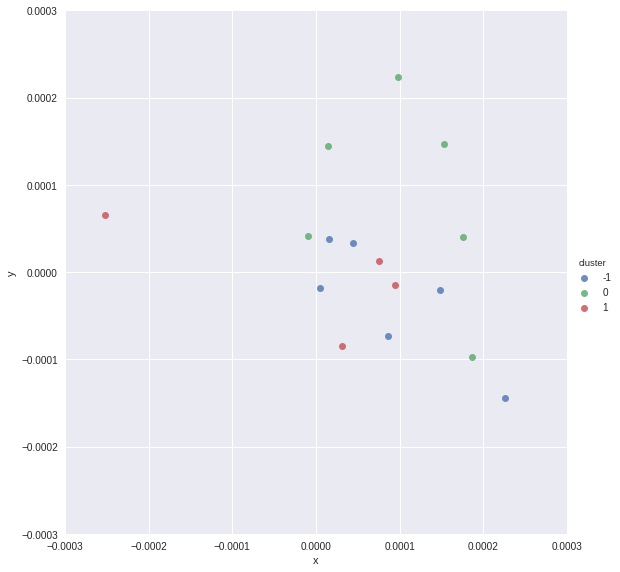

In [358]:
ax = sns.lmplot('x', 'y', chart, fit_reg = False, size = 8, hue = 'cluster')
axes = ax.axes

axes[0,0].set_ylim(-0.0003,0.0003)
axes[0,0].set_xlim(-0.0003,0.0003)

In [302]:
hole_info_df = horsey_df[['course_id', 'hole_no', 'left_to_pin_before', 'par', 'shot_no']].loc[horsey_df['shot_no'] \
            == 1].groupby(['course_id', 'hole_no']).mean()

hole_info_df.reset_index(inplace = True)
hole_info_df['left_to_pin_before'] = hole_info_df['left_to_pin_before'] / 36
course_totals_df = hole_info_df[['course_id', 'par', 'left_to_pin_before']].groupby(['course_id']).sum()
course_totals_df.reset_index(inplace = True)
course_totals_df

,course_id,par,left_to_pin_before
0,4,71,6786.000000
1,5,72,7282.500000
2,12,71,6991.250000
3,13,71,6826.333333
4,16,72,7211.500000
5,17,72,7258.000000
6,18,72,7104.000000
7,21,71,7037.750000
8,26,71,7146.500000
9,47,72,7663.000000


In [416]:
horsey_sg_total = horsey_df[['course_id', 'round_no', 'round_date', 'stroke_gained']].groupby(['course_id',
                            'round_no', 'round_date']).sum()

horsey_sg_total.reset_index(inplace = True)

horsey_stroke_info = horsey_df[['course_id', 'round_date', 'round_no', 'score', 'par', 'shot_no']].loc[horsey_df['shot_no']
                == 1].groupby(['course_id', 'round_date', 'round_no']).sum()
    
horsey_stroke_info.reset_index(inplace = True)

horsey_scoring = horsey_sg_total.merge(horsey_stroke_info, on = ['course_id', 'round_no'])
horsey_course_scoring = horsey_scoring[['course_id', 'stroke_gained', 'score', 'par']].groupby(
                    ['course_id']).mean()

horsey_course_scoring.reset_index(inplace = True)

horsey_course_scoring

,course_id,stroke_gained,score,par
0,4,-5.830000,76.00,71.0
1,5,0.545000,71.50,72.0
2,12,3.775000,67.00,71.0
3,13,1.213333,69.00,71.0
4,16,1.530000,70.50,72.0
5,17,2.840000,69.00,72.0
6,18,5.460000,66.00,72.0
7,21,3.905000,67.25,71.0
8,26,-5.455000,77.00,71.0
9,47,-0.585000,73.75,72.0


In [351]:
course_df_2 = course_df[['course_name', 'course_id', 'cluster']].merge(course_totals_df, 
                on = 'course_id', how = 'inner')

course_df_2 = course_df_2.merge(horsey_course_scoring, on = 'course_id', how = 'inner')
course_df_2

,course_name,course_id,cluster,par_x,left_to_pin_before,stroke_gained,score,par_y
0,"The Earth Course, Jumeirah Golf Estates",48.0,0,72,7408.000000,3.180000,69.25,72.0
1,Gary Player Country Club,47.0,0,72,7663.000000,-0.585000,73.75,72.0
2,Golfclub München Eichenried,63.0,0,72,7070.500000,1.300000,69.75,72.0
3,Le Golf National,26.0,1,71,7146.500000,-5.455000,77.00,71.0
4,Castle Stuart,64.0,0,72,6992.500000,-2.720000,74.00,72.0
5,The Albatross,5.0,0,72,7282.500000,0.545000,71.50,72.0
6,Golf Club Milano,12.0,1,71,6991.250000,3.775000,67.00,71.0
7,Himmerland,4.0,2,71,6786.000000,-5.830000,76.00,71.0
8,Heritage Course London Golf Club,13.0,3,71,6826.333333,1.213333,69.00,71.0
9,The Grove,95.0,1,71,7006.250000,2.707750,68.50,71.0


In [352]:
slope, intercept, r_value, p_value, std_err = stats.linregress(course_df_2['cluster'], 
                            course_df_2['stroke_gained'])
p_value

0.70608977456850597

In [449]:
weather_dict

{'12_2016-09-15': [{'apparentTemperature': 65.66,
   'cloudCover': 0.31,
   'dewPoint': 58.67,
   'humidity': 0.78,
   'icon': 'partly-cloudy-night',
   'precipIntensity': 0,
   'precipProbability': 0,
   'pressure': 1014.85,
   'summary': 'Partly Cloudy',
   'temperature': 65.66,
   'time': 1473890400,
   'time_str': '09/14/2016 17:00',
   'visibility': 6.03,
   'windBearing': 114,
   'windSpeed': 2.7},
  {'apparentTemperature': 65.45,
   'cloudCover': 0.31,
   'dewPoint': 59.62,
   'humidity': 0.81,
   'icon': 'partly-cloudy-night',
   'precipIntensity': 0.0021,
   'precipProbability': 0.05,
   'precipType': 'rain',
   'pressure': 1014.83,
   'summary': 'Partly Cloudy',
   'temperature': 65.45,
   'time': 1473894000,
   'time_str': '09/14/2016 18:00',
   'visibility': 5.98,
   'windBearing': 138,
   'windSpeed': 1.54},
  {'apparentTemperature': 65.46,
   'cloudCover': 0.48,
   'dewPoint': 59.32,
   'humidity': 0.81,
   'icon': 'partly-cloudy-night',
   'precipIntensity': 0.0021,
   '

In [402]:
weather_summary = pd.DataFrame(columns = ['course_id', 'round_date', 'temp_avg', 'wind_avg', 'humidity_avg',
                                         'summary'])

for k, key in enumerate(weather_dict.keys()):
    course_id = key.split('_')[0]
    round_date = key.split('_')[1]
    temp_total = 0
    wind_total = 0
    humid_total = 0
    summary_ls = []
    hour_count = 0
    for hour in weather_dict[key]:
        hour_split = hour['time_str'].split(' ')[0].split('/')
        hour_date = hour_split[2] + '-' + hour_split[0] + '-' + hour_split[1]
        hour_hour = int(hour['time_str'].split(' ')[1].split(':')[0])
        
        if round_date == hour_date and hour_hour > 7 and hour_hour < 18:
            try:
                temp_total += hour['temperature']
                wind_total += hour['windSpeed']
                humid_total += hour['humidity']
                summary_ls.append(hour['summary'])
                hour_count += 1
            except:
                pass
    temp_avg = temp_total / hour_count
    wind_avg = wind_total / hour_count
    humid_avg = humid_total / hour_count
    summary = stats.mode(summary_ls)[0][0]
    weather_summary.loc[k] = [course_id, round_date, temp_avg, wind_avg, humid_avg, summary]
    

/home/valesco/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [435]:
horsey_scoring_round = horsey_scoring_round.rename(columns = {'round_date_x': 'round_date'})

horsey_scoring_round = horsey_scoring_round.merge(weather_summary, on = 'round_date')

horsey_scoring_round

,course_id_x,round_no,round_date,stroke_gained,round_date_y,score,par,shot_no,course_id_y,temp_avg,wind_avg,humidity_avg,summary
0,4,1,2016-08-25,-4.830,2016-08-25,75,71,18,4,76.327778,3.540000,0.683333,Clear
1,4,2,2016-08-26,-6.830,2016-08-26,77,71,18,4,64.070000,12.020000,0.807778,Mostly Cloudy
2,5,1,2016-08-18,0.480,2016-08-18,72,72,18,5,70.022222,3.458889,0.441111,Partly Cloudy
3,5,2,2016-08-19,1.130,2016-08-19,71,72,18,5,74.031111,2.551111,0.390000,Partly Cloudy
4,5,3,2016-08-20,-0.120,2016-08-20,72,72,18,5,77.123333,2.712222,0.514444,Mostly Cloudy
5,5,4,2016-08-21,0.690,2016-08-21,71,72,18,5,63.218889,7.054444,0.688889,Partly Cloudy
6,12,1,2016-09-15,3.770,2016-09-15,67,71,18,12,66.833333,5.210000,0.796667,Mostly Cloudy
7,12,2,2016-09-16,3.530,2016-09-16,67,71,18,12,61.095556,2.452222,0.872222,Mostly Cloudy
8,12,3,2016-09-17,2.000,2016-09-17,69,71,18,12,64.906667,1.537778,0.704444,Mostly Cloudy
9,12,4,2016-09-18,5.800,2016-09-18,65,71,18,12,63.461111,2.560000,0.707778,Partly Cloudy


In [485]:
summary_dummies = pd.get_dummies(horsey_scoring_round['summary'])

#horsey_scoring_round = pd.concat([horsey_scoring_round, summary_dummies], axis = 1)
scoring_cols = ['round_no', 'par', 'temp_avg', 'wind_avg', 'humidity_avg']
scoring_cols.extend(summary_dummies.columns)

for col in ['miles_dist']:
    slope, intercept, r_value, p_value, std_err = stats.linregress(horsey_scoring_round[col], 
                            horsey_scoring_round['stroke_gained'])
    
    print(col, r_value, p_value)

miles_dist 0.165401856255 0.256053748603


In [483]:
horsey_scoring_round = horsey_scoring_round.rename(columns = {'course_id_x': 'course_id'})
horsey_scoring_round = horsey_scoring_round.merge(course_loc[['miles_dist', 'course_id']], on = 'course_id')
horsey_scoring_round

,par,shot_no,round_no,humidity_avg,Partly Cloudy,Clear,summary,score,course_id,course_id_y,Light Rain,Mostly Cloudy,wind_avg,temp_avg,stroke_gained,round_date_y,round_date,Overcast,miles_dist
0,71,18,1,0.683333,0,1,Clear,75,4,4,0,0,3.540000,76.327778,-4.830,2016-08-25,2016-08-25,0,522.445583
1,71,18,2,0.807778,0,0,Mostly Cloudy,77,4,4,0,1,12.020000,64.070000,-6.830,2016-08-26,2016-08-26,0,522.445583
2,72,18,1,0.441111,1,0,Partly Cloudy,72,5,5,0,0,3.458889,70.022222,0.480,2016-08-18,2016-08-18,0,741.125162
3,72,18,2,0.390000,1,0,Partly Cloudy,71,5,5,0,0,2.551111,74.031111,1.130,2016-08-19,2016-08-19,0,741.125162
4,72,18,3,0.514444,0,0,Mostly Cloudy,72,5,5,0,1,2.712222,77.123333,-0.120,2016-08-20,2016-08-20,0,741.125162
5,72,18,4,0.688889,1,0,Partly Cloudy,71,5,5,0,0,7.054444,63.218889,0.690,2016-08-21,2016-08-21,0,741.125162
6,71,18,1,0.796667,0,0,Mostly Cloudy,67,12,12,0,1,5.210000,66.833333,3.770,2016-09-15,2016-09-15,0,741.319185
7,71,18,2,0.872222,0,0,Mostly Cloudy,67,12,12,0,1,2.452222,61.095556,3.530,2016-09-16,2016-09-16,0,741.319185
8,71,18,3,0.704444,0,0,Mostly Cloudy,69,12,12,0,1,1.537778,64.906667,2.000,2016-09-17,2016-09-17,0,741.319185
9,71,18,4,0.707778,1,0,Partly Cloudy,65,12,12,0,0,2.560000,63.461111,5.800,2016-09-18,2016-09-18,0,741.319185


In [468]:
geolocator = nm()
home_coords = geolocator.geocode('Alderley Edge, England')
home_coords[1][0]

Location(Alderley Edge, Cheshire East, North West England, England, UK, (53.3058355, -2.2375777, 0.0))

In [478]:
home_coords[1]

(53.3058355, -2.2375777)